In [1]:
# Import all necessary Python packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# Variables related to the data analysis

dataset_path = '../data/bank-additional-full.csv'

### 1. Data Analysis

In [3]:
# Loading the data
data = pd.read_csv(dataset_path)

In [4]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### 1.1 Understanding the data

#### Input variables:

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

##### Related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

##### Other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

##### Social and economic context attributes:

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)
Output variable (desired target):

21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [5]:
# Overview of the data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
# Overall Data Distribution

data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
# Input Data Shape

data.shape

(41188, 21)

In [8]:
# Checking for the missing values in the dataset

print(data.isnull().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


#### There is no missing data in the dataset

In [9]:
# Checking for 'unknown' values in all categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
for index, column in enumerate(categorical_columns):
    unknowns = (data[column] == 'unknown').sum()
    if unknowns > 0:
        print(f"{column} has {unknowns} 'unknown' values")

job has 330 'unknown' values
marital has 80 'unknown' values
education has 1731 'unknown' values
default has 8597 'unknown' values
housing has 990 'unknown' values
loan has 990 'unknown' values


#### Currently not handling the unknown values, as in the test dataset also unknown values might be present

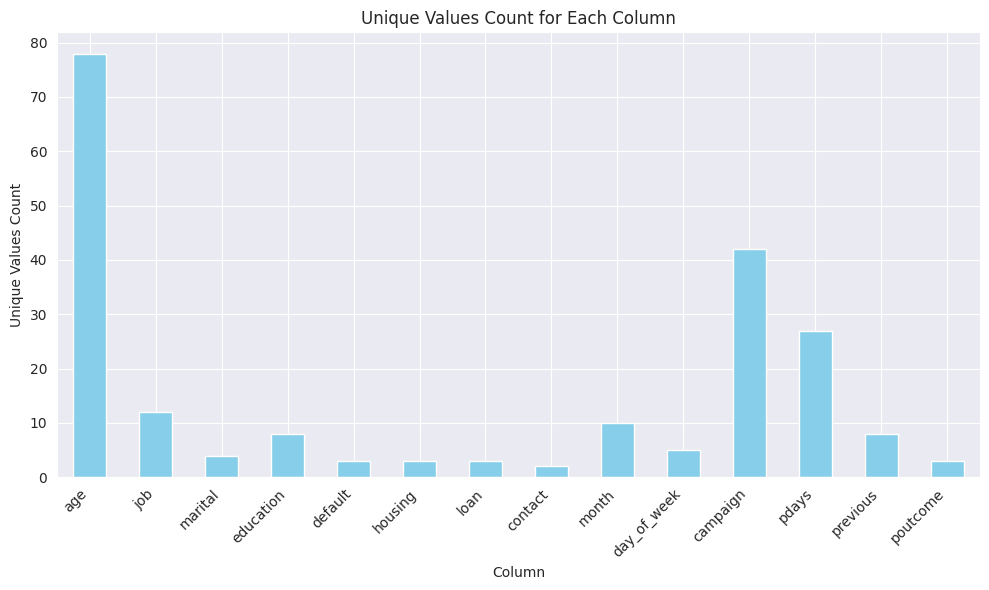

In [10]:
# Finding the unique values count for each of the columns.
# Not considering the below columns as few are 'Social and Economic related' features and duration of the call is removed.

dataset = data.copy()

columns_to_remove = ['duration', 'y', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
dataset.drop(columns_to_remove, axis=1, inplace=True)

unique_value_counts = dataset.nunique()

# Plot a grouped bar chart
plt.figure(figsize=(10, 6))
unique_value_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Column')
plt.ylabel('Unique Values Count')
plt.title('Unique Values Count for Each Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Age, campaign, pdays, job are having most number of unique values. This also signifes that grouping the 'Age' column in groups will be more benefical for the model

#### *Removing the duration column from the data, as we are trying to predict if the call should be made or not, so duration doesnt have importance

### 1.2 Feature Engineering

In [11]:
# Convert Target Variable(y) into numeric
data.y = data.y.map({'no':0, 'yes':1}).astype('uint8')

In [12]:
# Identify categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns
print(f"Total of categorical columns : {len(categorical_cols)}")
print(categorical_cols)

# Identify numerical columns
# numerical_cols = data.select_dtypes(include=['uint8', 'float', 'int']).columns
numerical_cols = data.select_dtypes(include=['number']).columns

print(f"Total of numerical columns : {len(numerical_cols)}")
print(numerical_cols)

Total of categorical columns : 10
Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')
Total of numerical columns : 11
Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


In [13]:
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


### 1.2.1: Categorical Data


In [14]:
categorical_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

#### Explore categorical features (EDA) analysis

In [15]:
eda_folder_path = '../exploratory_analysis'
# Build a function to show categorical values disribution
def plot_bar(column):
    # temp df 
    temp_1 = pd.DataFrame()
    # count categorical values
    temp_1['No_deposit'] = data[data['y'] == 0][column].value_counts()
    temp_1['Yes_deposit'] = data[data['y'] == 1][column].value_counts()
    temp_1.plot(kind='bar', color=['salmon', 'limegreen'])
    plt.xlabel(f'{column}')
    plt.ylabel('Number of clients')
    plot_title = 'Distribution of {} and deposit'.format(column)
    plt.title(plot_title)
    plt.savefig(os.path.join(eda_folder_path, '{}.png'.format(plot_title)))
    plt.show()
    return True



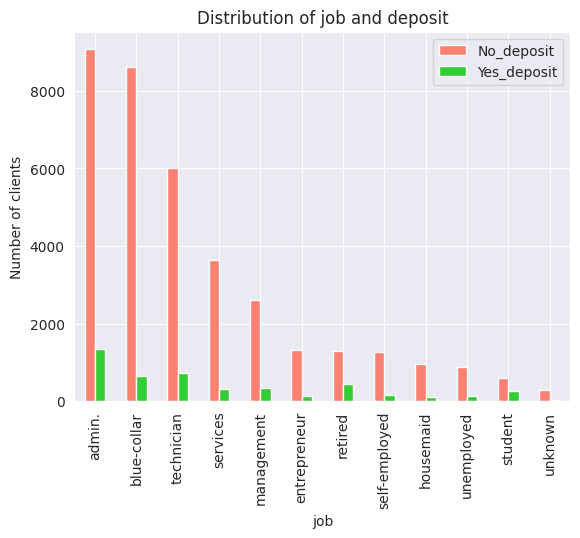

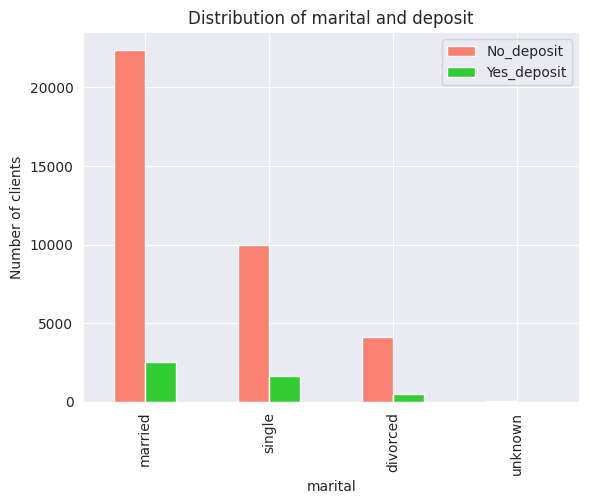

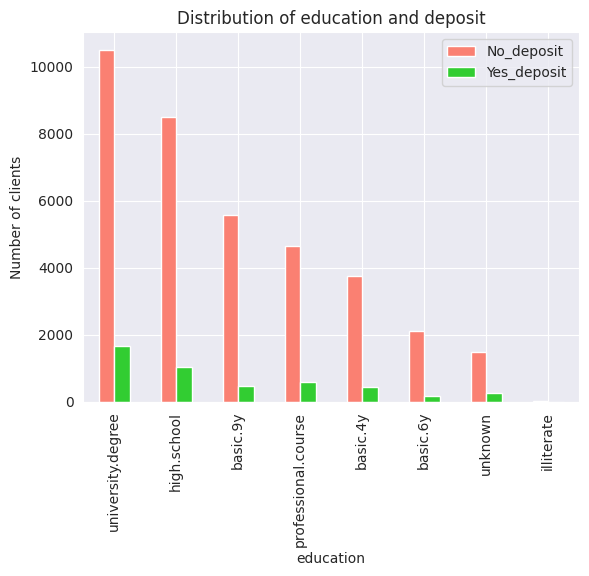

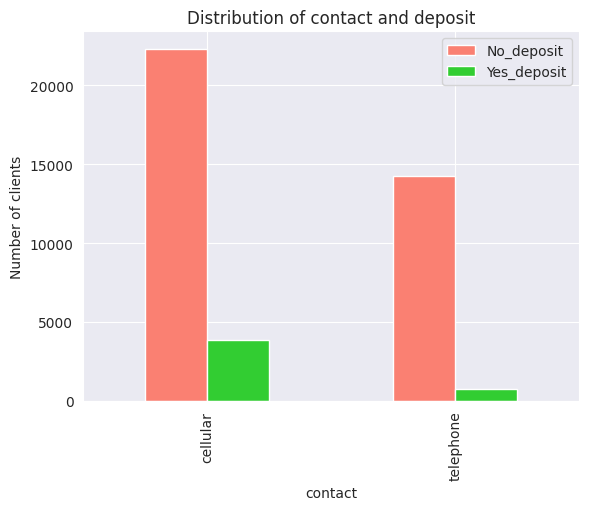

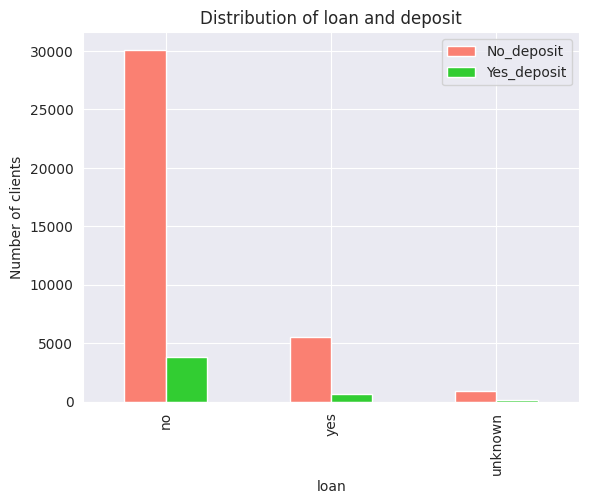

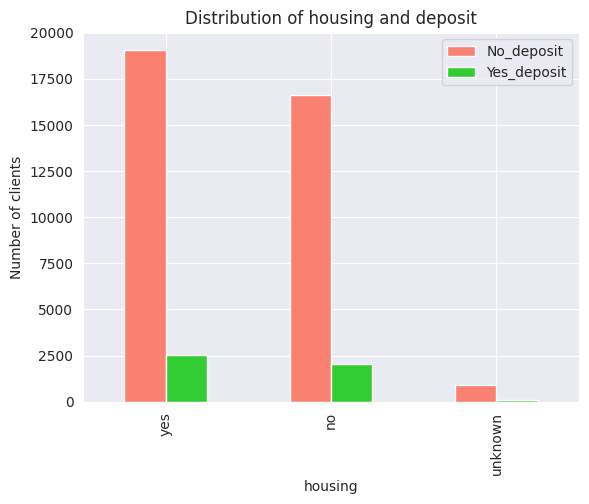

(True, True, True, True, True, True)

In [16]:
plot_bar('job'), plot_bar('marital'), plot_bar('education'), plot_bar('contact'), plot_bar('loan'), plot_bar('housing')

### Label Encoding for some categorical columns

In [17]:
cols_for_label_encoding = ['contact', 'loan', 'housing', 'default', 'poutcome']

In [18]:
label_encoder = LabelEncoder()

# Encode categorical columns
for col in cols_for_label_encoding:
    data[col] = label_encoder.fit_transform(data[col])

### Hot Encoding for some categorical columns

In [19]:
cols_for_hot_encoding = ['month', 'day_of_week']

In [20]:
# fucntion to One Hot Encoding
def encode(data, col):
    return pd.concat([data, pd.get_dummies(col, prefix=col.name, dtype='uint')], axis=1)

for col in cols_for_hot_encoding:
    data = encode(data, data[col])
    

# Drop tranfromed features
data.drop(cols_for_hot_encoding, axis=1, inplace=True)

### Target Encoding for some categorical columns

In [21]:
cols_for_target_encoding = ['job', 'marital', 'education']

In [22]:
def target_encode_columns(data, columns_to_encode, target_column):
    """
    Encodes specified columns in the dataset using target encoding.

    Parameters:
    - data: A pandas DataFrame containing the data.
    - columns_to_encode: A list of column names (strings) to be target encoded.
    - target_column: The name of the target column (string).

    Returns:
    - A pandas DataFrame with the specified columns replaced by their target-encoded values.
    """
    # Ensure the input is a DataFrame to avoid attribute errors
    if not isinstance(data, pd.DataFrame):
        raise ValueError("data must be a pandas DataFrame")
    
    # Separate the features and the target
    X = data.drop(target_column, axis=1)
    y = data[target_column]
    
    # Create and fit the target encoder
    target_encoder = ce.TargetEncoder(cols=columns_to_encode)
    target_encoder.fit(X, y)
    
    # Transform the data and replace the original columns with encoded ones
    X_encoded = target_encoder.transform(X)
    
    # If the target column was dropped, add it back
    X_encoded[target_column] = y
    
    return X_encoded, target_encoder

In [23]:
data, target_encoder = target_encode_columns(data, cols_for_target_encoding, 'y')

In [24]:
target_encoder

TargetEncoder(cols=['job', 'marital', 'education'])

### 1.2.1: Numerical Data

In [25]:
numerical_cols

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

#### Explore numerical features (EDA)

In [26]:
# Build correlation matrix

subset = data[numerical_cols]

corr = subset.corr()
corr.style.background_gradient()


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678


In [27]:
subset.shape

(41188, 11)

#### --> Adding the Age Group column in the data

In [28]:

def find_quantile_bins(data, column_name, column_group_name, num_bins=6):

    # Ensure the column exists in the DataFrame
    if column_name not in data.columns:
        raise ValueError(f"{column_name} not found in DataFrame")

    # Ensure the column is numerical
    if not pd.api.types.is_numeric_dtype(data[column_name]):
        raise ValueError(f"{column_name} is not a numerical column")

    _, bin_edges = pd.qcut(data[column_name], q=num_bins, retbins=True, duplicates='drop')
    print(f"Quantile-based bin edges for {num_bins} bins: {bin_edges}")

    # Bin the data using the provided or calculated bin edges
    binned_data = pd.cut(data[column_name], bins=bin_edges, labels=False, include_lowest=True)

    # Convert binned data to integer
    binned_data = binned_data.astype(int)

    # Calculate the record counts for each bin
    bin_counts = binned_data.value_counts().sort_index()

    # Create a dictionary to store record counts for each bin
    bin_records = dict(bin_counts)
    
    data[column_group_name] = binned_data

    return bin_edges, bin_records, data


bin_edges, age_group_counts, data = find_quantile_bins(data, 'age', 'age_group')

print(age_group_counts)

Quantile-based bin edges for 6 bins: [17. 30. 34. 38. 44. 51. 98.]
{0: 7383, 1: 7371, 2: 6421, 3: 7079, 4: 6508, 5: 6426}


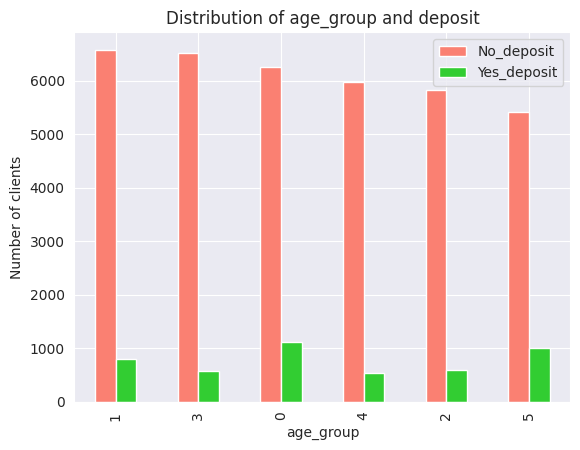

True

In [29]:
plot_bar('age_group')

#### --> Replacing 999 of 'pdays' column in the data

In [30]:
# Replace 999 with 0 for 'pdays' column
data.pdays = data.pdays.replace(999, 0)

### --> Normalizing the Social and economic context attributes

In [31]:
# change the range of Var Rate
data['emp.var.rate'] = data['emp.var.rate'].apply(lambda x: x*-0.0001 if x > 0 else x*1)
data['emp.var.rate'] = data['emp.var.rate'] * -1
data['emp.var.rate'] = data['emp.var.rate'].apply(lambda x: -np.log(x) if x < 1 else np.log(x)).astype('uint8')

# Multiply consumer index 
data['cons.price.idx'] = (data['cons.price.idx'] * 10).astype('uint8')

# change the sign (we want all be positive values)
data['cons.conf.idx'] = data['cons.conf.idx'] * -1

# re-scale variables
data['nr.employed'] = np.log2(data['nr.employed']).astype('uint8')
data['cons.price.idx'] = np.log2(data['cons.price.idx']).astype('uint8')
data['cons.conf.idx'] = np.log2(data['cons.conf.idx']).astype('uint8')

# less space
data.euribor3m = data.euribor3m.astype('uint8')
data.campaign = data.campaign.astype('uint8')
data.pdays = data.pdays.astype('uint8')

In [32]:
'''Drop the dublicates'''
data.drop_duplicates(inplace=True) 

In [33]:
data.shape

(41175, 35)

In [34]:
# save target variable before transformation
y = data.y

In [35]:
# Dropping the columns that are not required

cols_to_drop = ['age', 'duration', 'y']

data.drop(cols_to_drop, axis=1, inplace=True)

data

,job,marital,education,default,housing,loan,contact,campaign,pdays,previous,...,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,age_group
0,0.100000,0.101573,0.102490,0,0,0,1,1,0,0,...,1,0,0,0,0,1,0,0,0,5
1,0.081381,0.101573,0.108355,1,0,0,1,1,0,0,...,1,0,0,0,0,1,0,0,0,5
2,0.081381,0.101573,0.108355,0,2,0,1,1,0,0,...,1,0,0,0,0,1,0,0,0,2
3,0.129726,0.101573,0.082024,0,0,0,1,1,0,0,...,1,0,0,0,0,1,0,0,0,3
4,0.081381,0.101573,0.108355,0,0,2,1,1,0,0,...,1,0,0,0,0,1,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.252326,0.101573,0.113485,0,2,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,5
41184,0.068943,0.101573,0.113485,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,4
41185,0.252326,0.101573,0.137245,0,2,0,0,2,0,0,...,0,1,0,0,1,0,0,0,0,5
41186,0.108260,0.101573,0.113485,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,3


In [36]:
''' Split data on train and test'''
# set global random state
random_state = 44

# split data
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=random_state,  stratify=y)
# collect excess data
gc.collect()

25807

### Applying the SMOTE for oversampling

In [38]:
# Summarize class distribution
print("Before SMOTE:", Counter(y_train))

Before SMOTE: Counter({0: 29229, 1: 3711})


In [39]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 32940 entries, 23702 to 40091
Series name: y
Non-Null Count  Dtype
--------------  -----
32940 non-null  uint8
dtypes: uint8(1)
memory usage: 289.5 KB


In [40]:
# Define SMOTE
sm = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Summarize the new class distribution
print("After SMOTE:", Counter(y_train_res))

After SMOTE: Counter({0: 29229, 1: 29229})


In [41]:
X_train_res

,job,marital,education,default,housing,loan,contact,campaign,pdays,previous,...,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,age_group
0,0.108260,0.140041,0.113485,0,2,0,0,2,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0.129726,0.101573,0.137245,0,0,0,0,2,0,0,...,0,1,0,0,0,0,0,1,0,1
2,0.068943,0.101573,0.113485,1,0,0,0,20,0,0,...,0,0,0,0,0,0,0,1,0,3
3,0.081381,0.101573,0.108355,0,0,0,1,1,0,0,...,1,0,0,0,0,1,0,0,0,3
4,0.068943,0.101573,0.078246,1,0,2,0,3,0,0,...,1,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58453,0.229792,0.108643,0.108878,0,2,2,0,3,0,0,...,0,0,0,0,1,0,0,0,0,5
58454,0.089189,0.140041,0.116747,1,0,0,0,3,0,0,...,0,0,0,0,0,0,0,1,0,0
58455,0.149104,0.101573,0.139289,0,2,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,4
58456,0.082761,0.138943,0.113338,0,2,0,0,2,0,0,...,1,0,0,0,0,0,1,0,0,0


In [42]:

# Create directories if they don't exist
train_folder = '../data/train_data'
test_folder = '../data/test_data'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Save X_train to train folder
X_train_res.to_csv(os.path.join(train_folder, 'X_train_res.csv'), index=False)

# Save X_test to test folder
X_test.to_csv(os.path.join(test_folder, 'X_test.csv'), index=False)

# Save y_train to train folder
pd.DataFrame(y_train_res, columns=['y']).to_csv(os.path.join(train_folder, 'y_train_res.csv'), index=False)

# Save y_test to test folder
pd.DataFrame(y_test, columns=['y']).to_csv(os.path.join(test_folder, 'y_test.csv'), index=False)


In [52]:
X_train.shape

(32940, 32)

In [53]:
y_train.shape

(32940,)

In [54]:
X_test.shape

(8235, 32)

In [55]:
y_test.shape

(8235,)